# Project 02 - Image Processing

## Student Information

- Full name: Nguyễn Trọng Nhân
- Student ID: 22127306
- Class: 22CLC08

## Required Libraries

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Function Definitions

In [12]:
def read_img(img_path):
    img = Image.open(img_path).convert('RGB')
    img_2d = np.array(img).astype(np.int16)
    return img_2d

def show_img(img_2d, title):
    image = Image.fromarray(img_2d, 'RGB')
    plt.imshow(image)
    plt.axis('off')  
    plt.title(title)
    plt.show()

def save_img(img_2d, img_path):
    image = Image.fromarray(img_2d, 'RGB')
    image.save(img_path)

def brightness_img(img_2d):
    """
    Adjusts the brightness of the input 2D image.
    """
    brighter_img = img_2d + 75
    darker_img = img_2d - 75
    return np.clip(brighter_img, 0, 255).astype(np.uint8), np.clip(darker_img, 0, 255).astype(np.uint8)

def contrast_img(img_2d):
    """
    Adjusts the contrast of the input 2D image.
    """
    factor = 1.5
    mean = np.mean(img_2d)
    high_contrast = np.clip((img_2d - mean) * factor + mean, 0, 255).astype(np.uint8)
    low_contrast = np.clip((img_2d - mean) * (1 / factor) + mean, 0, 255).astype(np.uint8)
    return high_contrast, low_contrast

def flip_img(img_2d):
    """
    Flips the input 2D image horizontally and vertically.
    """
    return np.flip(img_2d, axis=1).astype(np.uint8), np.flip(img_2d, axis=0).astype(np.uint8) # return flip image horizontally, flip image vertically

def gray_img(img_2d):
    """
    Converts the input RGB image to grayscale.
    """
    gray = np.dot(img_2d[...,:3], [0.2989, 0.5870, 0.1140])
    gray_rgb_img = np.stack([gray] * 3, axis=-1)
    return gray_rgb_img.astype(np.uint8)

def sepia_img(img_2d):
    """
    Applies a sepia filter to the input RGB image.
    """
    tr = np.dot(img_2d[...,:3] , [0.393, 0.769, 0.189])
    tg = np.dot(img_2d[...,:3] , [0.349, 0.686, 0.168])
    tb = np.dot(img_2d[...,:3] , [0.272, 0.534, 0.131])
    sepia = np.stack((tr, tg, tb), axis=-1)
    return np.clip(sepia, 0, 255).astype(np.uint8)

def crop_circular_img(img_2d):
    """
    Crops the input 2D image into a shape formed by largest posible circle.
    """
    height, width = img_2d.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    center = (width // 2, height // 2)
    radius = min(width, height) // 2
    col, row = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((row - center[0])**2 + (col - center[1])**2)
    mask[dist_from_center <= radius] = 1
    mask_rgb = np.stack([mask]*3, axis=-1)
    masked_img = img_2d * (mask_rgb)
    return masked_img.astype(np.uint8)

def crop_elliptical_img(img_2d):
    """
    Crops the input 2D image into a shape formed by two crossed ellipses.
    """
    height, width = img_2d.shape[:2]
    col, row = np.ogrid[:height, :width]
    center_y, center_x = height // 2, width // 2
    a = (min(height, width) * np.sqrt(6)) / 4
    b = (min(height, width) * np.sqrt(2)) / 4
    angle1 = np.pi / 4
    X_rotate1 = (row - center_x) * np.cos(angle1) + (col - center_y) * np.sin(angle1)
    Y_rotate1 = (row - center_x) * np.sin(angle1) - (col - center_y) * np.cos(angle1)
    equation_1 = (X_rotate1**2 / a**2) + (Y_rotate1**2 / b**2) <= 1
    angle2 = -np.pi / 4
    X_rotate2 = (row - center_x) * np.cos(angle2) + (col - center_y) * np.sin(angle2)
    Y_rotate2 = (row - center_x) * np.sin(angle2) - (col - center_y) * np.cos(angle2)
    equation_2 = (X_rotate2**2 / a**2) + (Y_rotate2**2 / b**2) <= 1
    crossed_ellipses_mask = equation_1 | equation_2
    mask_rgb = np.stack([crossed_ellipses_mask]*3, axis=-1)
    crossed_ellipses_img = img_2d * mask_rgb

    return crossed_ellipses_img.astype(np.uint8)

def create_kernel(sigma, size):
    """
    Creates a Gaussian kernel.
    """
    x = np.linspace(-(size // 2), size // 2, size)
    kernel = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-((x * 2) / (2 * sigma * 2)))
    kernel /= np.sum(kernel)
    return kernel

def blur_img(img_2d, sigma=2.5, size=5):
    """
    Blurs the input 2D image using a Gaussian kernel.
    """
        
    img_2d = img_2d.astype(float) / 255.0
    kernel = create_kernel(sigma, size)
    blurred_image = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis = 0, arr = img_2d)
    blurred_image = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis = 1, arr = blurred_image)
    blurred_image = np.clip(blurred_image * 255, 0, 255).astype(np.uint8)
    
    return blurred_image

def sharpen_img(img_2d, sigma=1.5, size=5):
    """
    Sharpens the input 2D image using a convolution kernel.
    """
    identity = np.zeros(size)
    identity[size//2] = 2  
    kernel = identity - create_kernel(sigma, size)
    sharpen_image = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis = 0, arr = img_2d)
    sharpen_image = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis = 1, arr = sharpen_image)
    sharpen_image = sharpen_image.clip(0, 255).astype(np.uint8)
    
    return sharpen_image

def crop_image(img_arr):
    """
    Crops the input image array to the largest possible centered square.
    """
    height, width = img_arr.shape[:2]
    size = min(height, width)
    
    if height != width:
        start_y = (height - size) // 2
        end_y = start_y + size
        start_x = (width - size) // 2
        end_x = start_x + size
    else:
        start_x = start_y = size // 4
        end_x = end_y = start_x * 3
    # Crop the image
    crop_arr = img_arr[start_y:end_y, start_x:end_x]
    return crop_arr.astype(np.uint8)

def zoom_img(img, scale):
    """
    Rescale an image by a fixed scale factor using bilinear interpolation.
    """
    height, width = img.shape[:2]
    new_height, new_width = int(height * scale), int(width * scale)
    rescaled_img = np.zeros((new_height, new_width, *img.shape[2:]), dtype=img.dtype)
    
    for i in range(new_height):
        for j in range(new_width):
            orig_x, orig_y = i / scale, j / scale

            x0, y0 = int(orig_x), int(orig_y)
            x1, y1 = min(x0 + 1, height - 1), min(y0 + 1, width - 1)
            
            dx, dy = orig_x - x0, orig_y - y0
            
            rescaled_img[i, j] = (
                img[x0, y0] * (1 - dx) * (1 - dy) +
                img[x1, y0] * dx * (1 - dy) +
                img[x0, y1] * (1 - dx) * dy +
                img[x1, y1] * dx * dy
            )
    
    return rescaled_img.astype(np.uint8)

<ins>Note:</ins> For clarity, include docstrings with each function.

## Your tests

In [13]:
# YOUR CODE HERE

## Main FUNCTION

In [14]:
def main():
    input_file = input("Enter the file's path:")
    img_2d = read_img(input_file)
    choice = int(input("0: All of the options\n1: Change brightness of image\n2: Change constrast of image\n3: Flip image\n4: Convert to gray/sepia image\n5: Convert to blur image\n6: Convert to sharpen image\n7: Crop image\n8: Crop image with circular and elliptical mask\n9: Zoom in/out image\nEnter your choice: "))
    show_img(img_2d.astype(np.uint8), "Normal image")
    if choice == 0 or choice == 1:
        brighter_img, darker_img = brightness_img(img_2d)
        show_img(brighter_img, "Brighter image")
        show_img(darker_img, "Darker image")
        save_img(brighter_img, "brighter.png")
        save_img(darker_img, "darker.png")
    if choice == 0 or choice == 2:
        high_contrast, low_contrast = contrast_img(img_2d)
        show_img(high_contrast, "High constrast image")
        show_img(low_contrast, "Low constrast image")
        save_img(high_contrast, "highConstrast.png")
        save_img(low_contrast, "lowConstrast.png")
    if choice == 0 or choice == 3:
        horizontal, vertical = flip_img(img_2d)
        show_img(horizontal, "Flip horizontally image")
        show_img(vertical, "Flip vertically image")
        save_img(horizontal, "horizontal.png")
        save_img(vertical, "vertical.png")
    if choice == 0 or choice == 4:
        gray = gray_img(img_2d)
        sepia = sepia_img(img_2d)
        show_img(gray, "Gray image")
        show_img(sepia, "Sepia image")
        save_img(gray, "gray.png")
        save_img(sepia, "sepia.png")
    if choice == 0 or choice == 5:
        blur_image = blur_img(img_2d)
        show_img(blur_image, "Blur image")
        save_img(blur_image, "blur.png")
    if choice == 0 or choice == 6:
        sharpen_image = sharpen_img(img_2d)
        show_img(sharpen_image, "Sharpen image")
        save_img(sharpen_image, "sharpen.png")
    if choice == 0 or choice == 7:
        crop = crop_image(img_2d)
        show_img(crop, "Crop image")
        save_img(crop, "crop.png")
    if choice == 0 or choice == 8:
        circle = crop_circular_img(img_2d)
        ellipse = crop_elliptical_img(img_2d)
        show_img(circle, "Circular mask image")
        show_img(ellipse, "Elliptical mask image")
        save_img(circle, "circle.png")
        save_img(ellipse, "ellipse.png")
    if choice == 9:
        scale = zoom_img(img_2d, 0.5)
        show_img(scale.astype(np.uint8), "Zoom in")
        save_img(scale.astype(np.uint8), "zoomin.png")
        scale = zoom_img(img_2d, 2)
        show_img(scale.astype(np.uint8), "Zoom out")
        save_img(scale.astype(np.uint8), "zoomout.png")

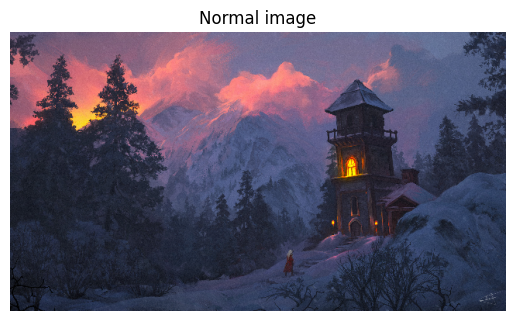

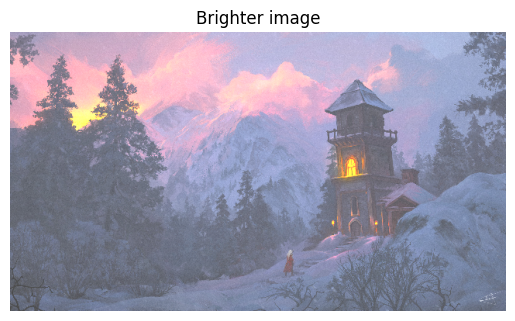

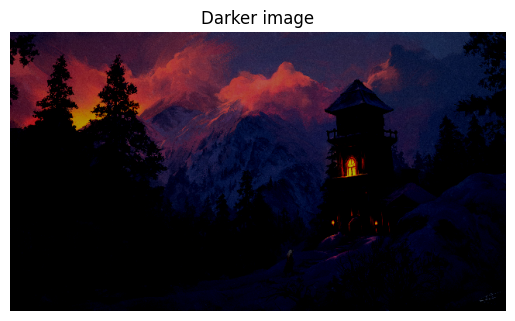

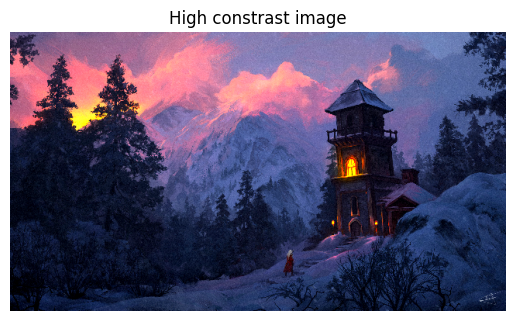

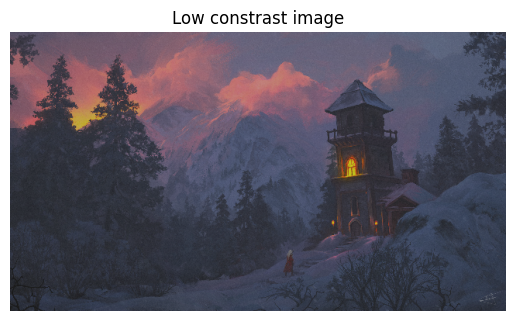

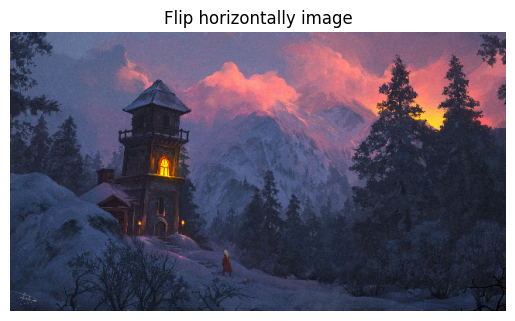

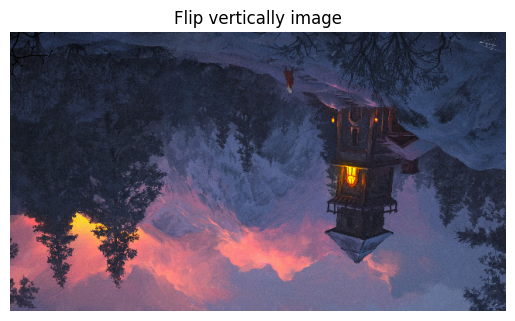

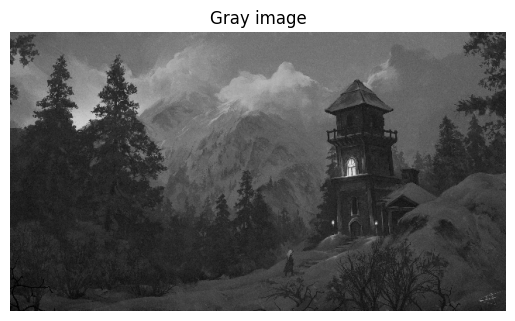

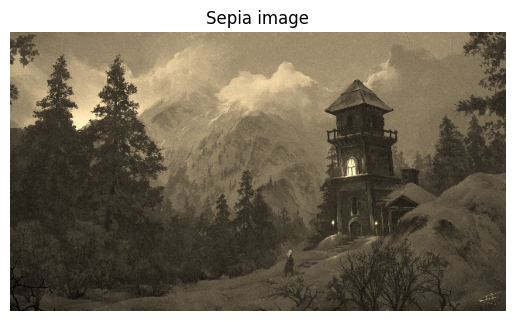

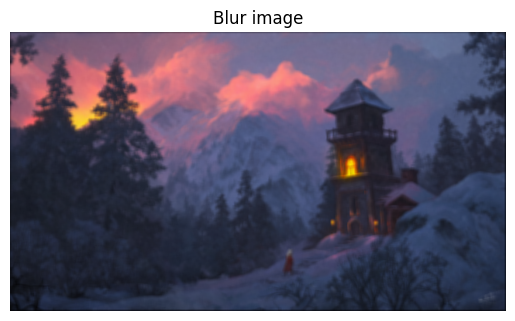

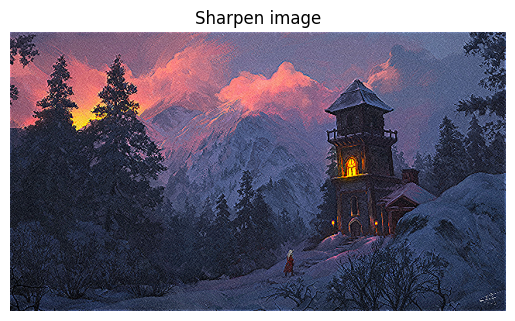

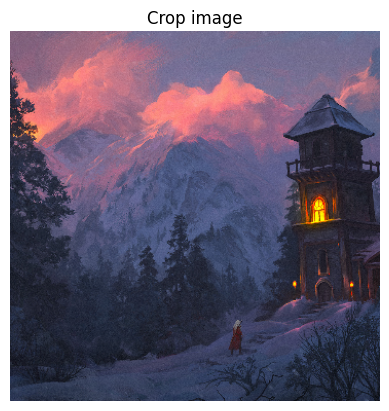

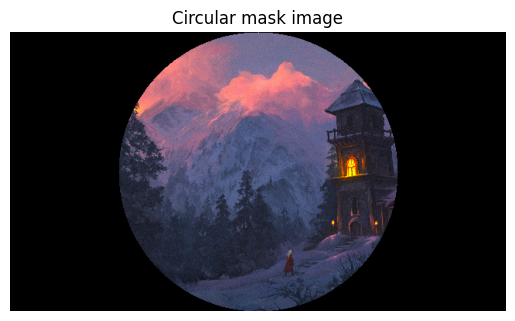

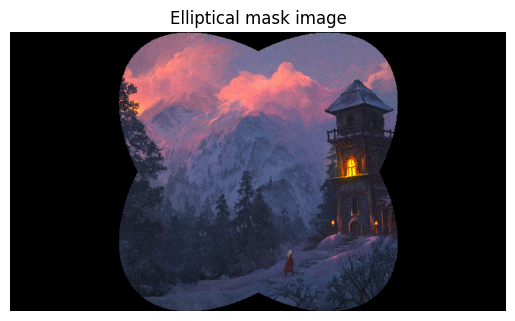

In [15]:
    # Call main function
main()